# 🤪 Conditional WGAN-GP on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own Conditional GAN on the CelebA faces dataset

The code has been adapted from the excellent [CGAN tutorial](https://keras.io/examples/generative/conditional_gan/) created by Sayak Paul, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display, sample_batch

2023-07-14 16:35:22.357254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 16:35:22.542708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-14 16:35:22.542728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-14 16:35:22.561820: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-14 16:35:23.057574: W tensorflow/stream_executor/platform/de

/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the label dataset
attributes = pd.read_csv("/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/data/img_align_celeba/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [4]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [5]:
train_data = utils.image_dataset_from_directory(
    '/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/data/img_align_celeba',
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


2023-07-14 16:35:27.867755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 16:35:27.867973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-14 16:35:27.868005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-14 16:35:27.868032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-14 16:35:27.868059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [7]:
# Show some faces from the training set
train_sample = sample_batch(train)

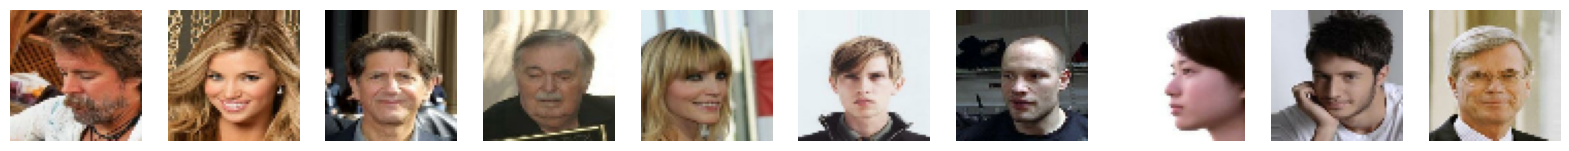

In [8]:
display(train_sample, cmap=None)

## 2. Build the GAN <a name="build"></a>

## Mathematical Overview

For this, we will keep everything the same except we are going to add something to the images we give the model. Consider an image and a one-hot vector of $S$ classes, $l \in \mathbb{R}^S$ (we are using $S$ as opposed to $C$ for reasons that will be apparent in a moment). We are going to upsize the vector into an image $\mathbf{l} \in \mathbb{R}^{H \times W \times S}$. We are then going to stack the image and the expanded image-like label to get an object $\tilde{\mathbf{x}} \in \mathbf{R}^{H \times W \times (C + S)}$:

$$ \tilde{\mathbf{x}} = \mathbf{x} \oplus \mathbf{l} $$

From here, the generator generates $\mathbf{x}_{Fake} = G_{\phi}(\mathbf{z} \oplus l)$ and the output (we are still using the Wasserstein Loss here) is $o = D_{\theta}(\mathbf{x}_{Real/Fake} \oplus \tilde{\mathbf{x}})$

We then treat the rest of the model as the exact same.

In [9]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES)) # We are giving the critic the concatenated image nad "image-like" label
x = layers.Concatenate(axis=-1)([critic_input, label_input]) # Concatenated here
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 5)    0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   5184        ['concatenate[0][0]']        

In [10]:
generator_input = layers.Input(shape=(Z_DIM,)) # The latent sample
label_input = layers.Input(shape=(CLASSES,)) # The label in one-hot shape
x = layers.Concatenate(axis=-1)([generator_input, label_input]) # We are concatenating the latent sample and the label
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x) # Expanding this vector so we can reshape it into an image
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 34)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 34)     0           ['concatenate_1[0][0]']    

In [11]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :] # Expanding labels, which have size (batch, classes) to (batch, H_input, W_input, classes)
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        ) # These populate the Height and Width so we get our "image-like label" of size (B, H, W, Classes)

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [13]:
if LOAD_MODEL:
    cgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [14]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 200 == 0: # We only want to see every 200th iteration, otherwise there'll be too much going on in the notebook
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            # 0 label
            zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
            generated_images = self.model.generator(
                [random_latent_vectors, zero_label]
            )
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_%03d_label_0.png" % (epoch),
                cmap=None,
            )

            # 1 label
            one_label = np.repeat([[0, 1]], self.num_img, axis=0)
            generated_images = self.model.generator(
                [random_latent_vectors, one_label]
            )
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_%03d_label_1.png" % (epoch),
                cmap=None,
            )

Epoch 1/2000


1/1 [==============================] - 5s 5s/step - c_loss: 7.3889 - c_wass_loss: -0.0634 - c_gp: 0.7452 - g_loss: -0.0133
Epoch 2/2000
1/1 [==============================] - 5s 5s/step - c_loss: 7.2287 - c_wass_loss: -0.1370 - c_gp: 0.7366 - g_loss: 0.0044
Epoch 3/2000
1/1 [==============================] - 4s 4s/step - c_loss: 6.9934 - c_wass_loss: -0.2465 - c_gp: 0.7240 - g_loss: 0.0370
Epoch 4/2000
1/1 [==============================] - 4s 4s/step - c_loss: 6.6572 - c_wass_loss: -0.4196 - c_gp: 0.7077 - g_loss: 0.0623
Epoch 5/2000
1/1 [==============================] - 4s 4s/step - c_loss: 6.2027 - c_wass_loss: -0.6745 - c_gp: 0.6877 - g_loss: 0.0966
Epoch 6/2000
1/1 [==============================] - 5s 5s/step - c_loss: 5.4893 - c_wass_loss: -1.1578 - c_gp: 0.6647 - g_loss: 0.1667
Epoch 7/2000
1/1 [==============================] - 3s 3s/step - c_loss: 4.9151 - c_wass_loss: -1.5034 - c_gp: 0.6419 - g_loss: 0.2786
Epoch 8/2000
1/1 [==============================] - 3s 3s/step - c_

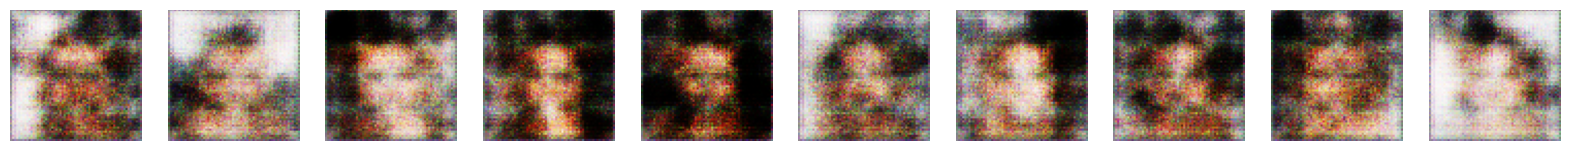


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_199_label_1.png


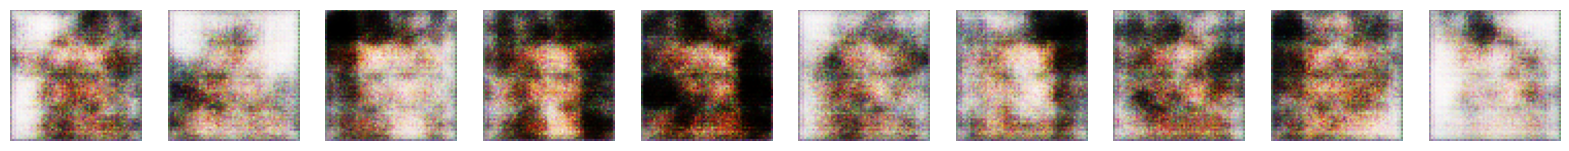

1/1 [==============================] - 4s 4s/step - c_loss: -8.1356 - c_wass_loss: -10.2396 - c_gp: 0.2104 - g_loss: 118.4092
Epoch 201/2000
1/1 [==============================] - 3s 3s/step - c_loss: -8.9936 - c_wass_loss: -10.8833 - c_gp: 0.1890 - g_loss: 119.7174
Epoch 202/2000
1/1 [==============================] - 3s 3s/step - c_loss: -10.8873 - c_wass_loss: -12.9619 - c_gp: 0.2075 - g_loss: 136.8103
Epoch 203/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.4223 - c_wass_loss: -9.6717 - c_gp: 0.2249 - g_loss: 128.8064
Epoch 204/2000
1/1 [==============================] - 3s 3s/step - c_loss: -9.7593 - c_wass_loss: -11.6813 - c_gp: 0.1922 - g_loss: 127.3820
Epoch 205/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.8361 - c_wass_loss: -8.3718 - c_gp: 0.1536 - g_loss: 119.4931
Epoch 206/2000
1/1 [==============================] - 3s 3s/step - c_loss: -9.5854 - c_wass_loss: -11.6584 - c_gp: 0.2073 - g_loss: 113.2031
Epoch 207/2000
1/1 [=========

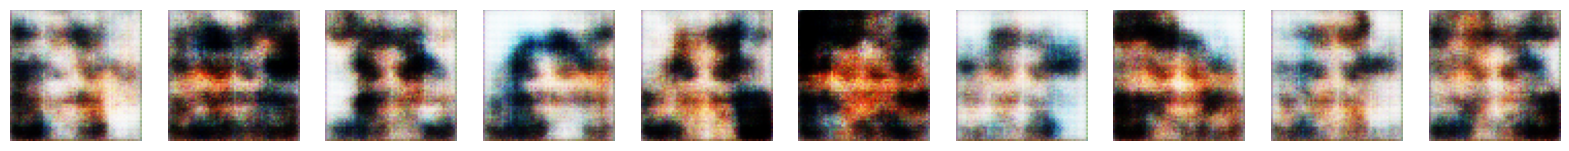


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_399_label_1.png


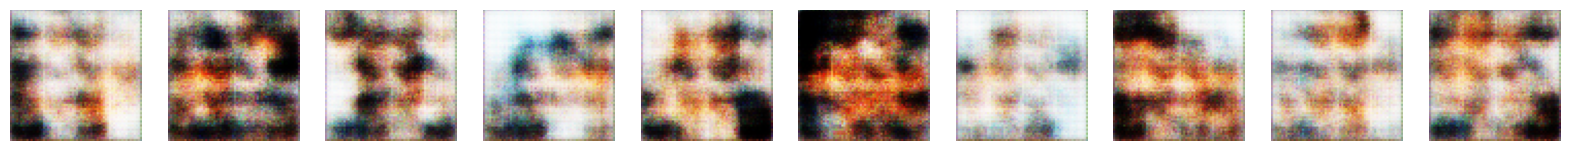

1/1 [==============================] - 4s 4s/step - c_loss: -7.2765 - c_wass_loss: -8.0852 - c_gp: 0.0809 - g_loss: 124.3568
Epoch 401/2000
1/1 [==============================] - 4s 4s/step - c_loss: -7.8833 - c_wass_loss: -8.7074 - c_gp: 0.0824 - g_loss: 134.2426
Epoch 402/2000
1/1 [==============================] - 3s 3s/step - c_loss: -11.3188 - c_wass_loss: -12.2120 - c_gp: 0.0893 - g_loss: 141.8190
Epoch 403/2000
1/1 [==============================] - 4s 4s/step - c_loss: -9.3593 - c_wass_loss: -10.3029 - c_gp: 0.0944 - g_loss: 144.2143
Epoch 404/2000
1/1 [==============================] - 4s 4s/step - c_loss: -9.7951 - c_wass_loss: -10.6093 - c_gp: 0.0814 - g_loss: 145.4990
Epoch 405/2000
1/1 [==============================] - 3s 3s/step - c_loss: -11.5763 - c_wass_loss: -12.4832 - c_gp: 0.0907 - g_loss: 144.8782
Epoch 406/2000
1/1 [==============================] - 3s 3s/step - c_loss: -11.5885 - c_wass_loss: -12.4787 - c_gp: 0.0890 - g_loss: 145.2002
Epoch 407/2000
1/1 [=======

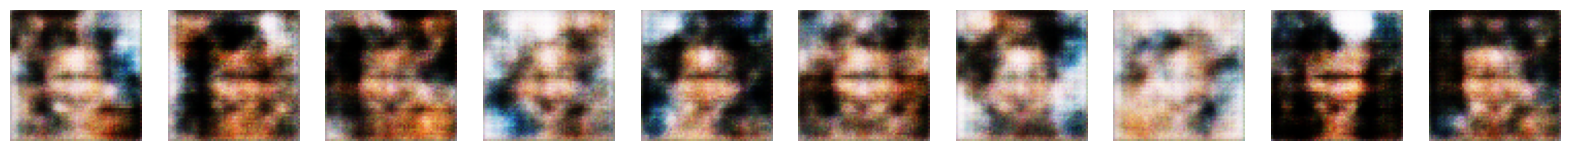


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_599_label_1.png


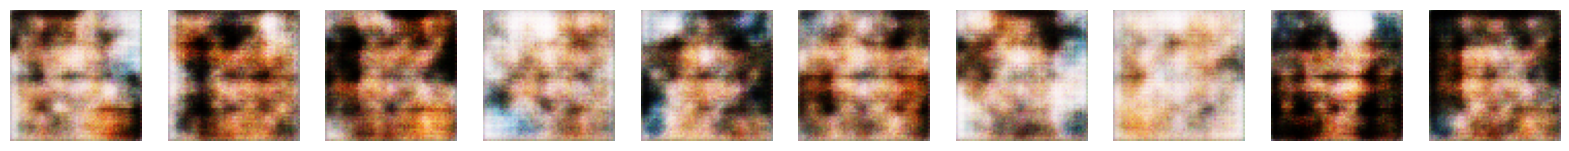

1/1 [==============================] - 4s 4s/step - c_loss: -0.9639 - c_wass_loss: -1.6991 - c_gp: 0.0735 - g_loss: 46.5066
Epoch 601/2000
1/1 [==============================] - 3s 3s/step - c_loss: -5.1671 - c_wass_loss: -5.8846 - c_gp: 0.0717 - g_loss: 49.1149
Epoch 602/2000
1/1 [==============================] - 3s 3s/step - c_loss: -1.9492 - c_wass_loss: -2.6693 - c_gp: 0.0720 - g_loss: 55.4165
Epoch 603/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.7317 - c_wass_loss: -7.3470 - c_gp: 0.0615 - g_loss: 50.8904
Epoch 604/2000
1/1 [==============================] - 3s 3s/step - c_loss: -4.4055 - c_wass_loss: -5.1163 - c_gp: 0.0711 - g_loss: 47.9624
Epoch 605/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.9577 - c_wass_loss: -8.6248 - c_gp: 0.0667 - g_loss: 55.9598
Epoch 606/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.3846 - c_wass_loss: -6.9194 - c_gp: 0.0535 - g_loss: 68.9444
Epoch 607/2000
1/1 [======================

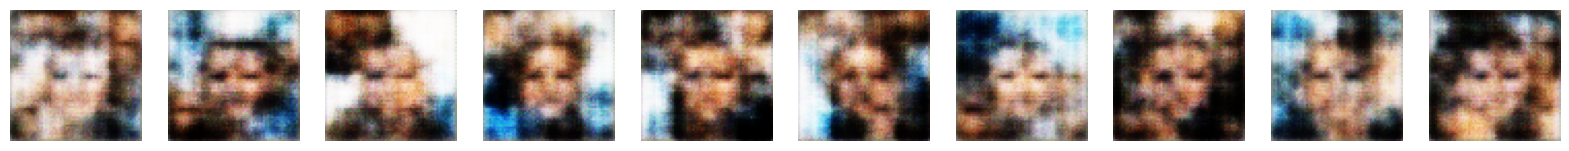


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_799_label_1.png


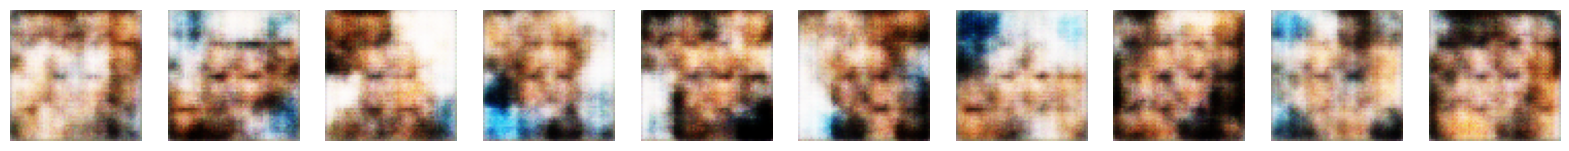

1/1 [==============================] - 4s 4s/step - c_loss: -2.7670 - c_wass_loss: -3.7618 - c_gp: 0.0995 - g_loss: 18.0688
Epoch 801/2000
1/1 [==============================] - 3s 3s/step - c_loss: -3.0452 - c_wass_loss: -3.9106 - c_gp: 0.0865 - g_loss: 16.0057
Epoch 802/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.1521 - c_wass_loss: -8.0054 - c_gp: 0.0853 - g_loss: 14.1983
Epoch 803/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.8068 - c_wass_loss: -7.5904 - c_gp: 0.0784 - g_loss: 11.2256
Epoch 804/2000
1/1 [==============================] - 3s 3s/step - c_loss: -3.6101 - c_wass_loss: -4.4725 - c_gp: 0.0862 - g_loss: 18.3263
Epoch 805/2000
1/1 [==============================] - 3s 3s/step - c_loss: 0.7066 - c_wass_loss: 0.0066 - c_gp: 0.0700 - g_loss: 22.1821
Epoch 806/2000
1/1 [==============================] - 3s 3s/step - c_loss: -5.7379 - c_wass_loss: -6.4212 - c_gp: 0.0683 - g_loss: 23.5965
Epoch 807/2000
1/1 [========================

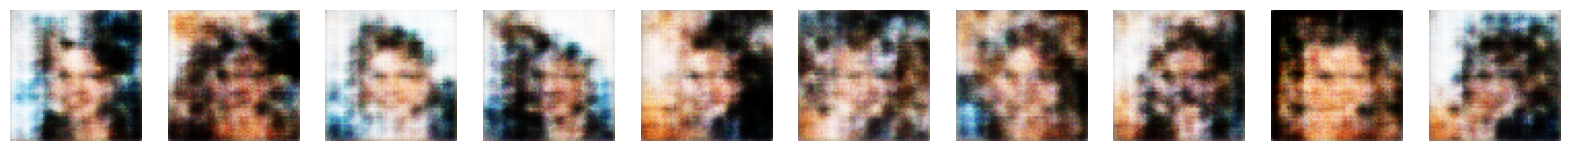


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_999_label_1.png


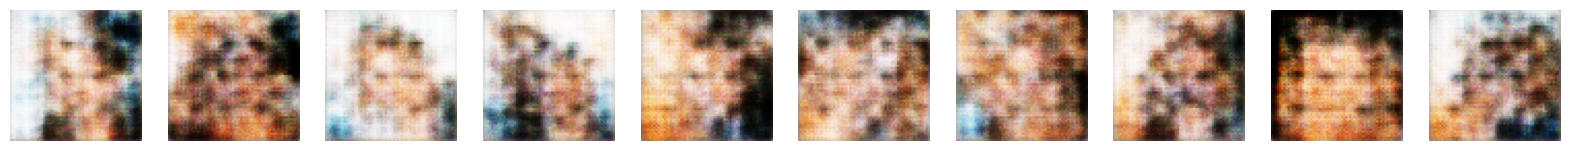

1/1 [==============================] - 4s 4s/step - c_loss: -2.6538 - c_wass_loss: -3.4611 - c_gp: 0.0807 - g_loss: 6.2620
Epoch 1001/2000
1/1 [==============================] - 3s 3s/step - c_loss: -2.1419 - c_wass_loss: -2.7333 - c_gp: 0.0591 - g_loss: 1.5019
Epoch 1002/2000
1/1 [==============================] - 3s 3s/step - c_loss: -3.3109 - c_wass_loss: -3.9948 - c_gp: 0.0684 - g_loss: -1.9290
Epoch 1003/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.2571 - c_wass_loss: -7.9781 - c_gp: 0.0721 - g_loss: -8.0337
Epoch 1004/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.5941 - c_wass_loss: -7.3089 - c_gp: 0.0715 - g_loss: -3.6548
Epoch 1005/2000
1/1 [==============================] - 3s 3s/step - c_loss: -3.2142 - c_wass_loss: -3.9942 - c_gp: 0.0780 - g_loss: -2.0923
Epoch 1006/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.0208 - c_wass_loss: -7.8982 - c_gp: 0.0877 - g_loss: 3.1896
Epoch 1007/2000
1/1 [==================

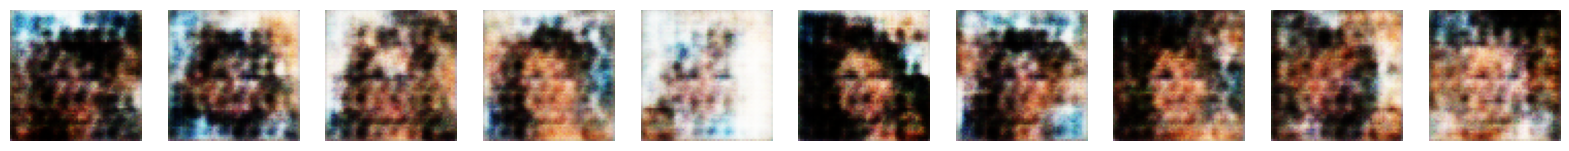


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_1199_label_1.png


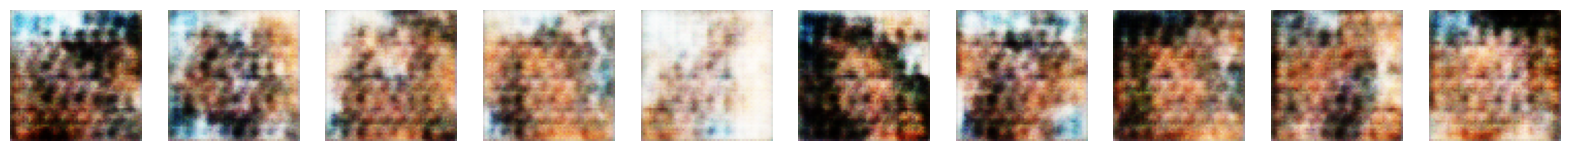

1/1 [==============================] - 4s 4s/step - c_loss: -5.6537 - c_wass_loss: -6.3029 - c_gp: 0.0649 - g_loss: -26.7218
Epoch 1201/2000
1/1 [==============================] - 3s 3s/step - c_loss: -11.8566 - c_wass_loss: -12.5722 - c_gp: 0.0716 - g_loss: -22.0620
Epoch 1202/2000
1/1 [==============================] - 3s 3s/step - c_loss: -7.5568 - c_wass_loss: -8.2893 - c_gp: 0.0733 - g_loss: -18.3668
Epoch 1203/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.1722 - c_wass_loss: -6.9916 - c_gp: 0.0819 - g_loss: -14.3244
Epoch 1204/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.6802 - c_wass_loss: -7.5119 - c_gp: 0.0832 - g_loss: -13.9651
Epoch 1205/2000
1/1 [==============================] - 3s 3s/step - c_loss: -8.7515 - c_wass_loss: -9.6943 - c_gp: 0.0943 - g_loss: -23.3118
Epoch 1206/2000
1/1 [==============================] - 3s 3s/step - c_loss: -11.9834 - c_wass_loss: -12.9152 - c_gp: 0.0932 - g_loss: -17.9515
Epoch 1207/2000
1/1 [====

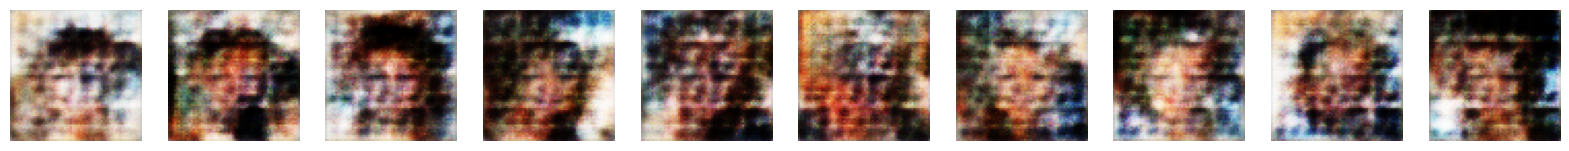


Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/03_cgan/output/generated_img_1399_label_1.png


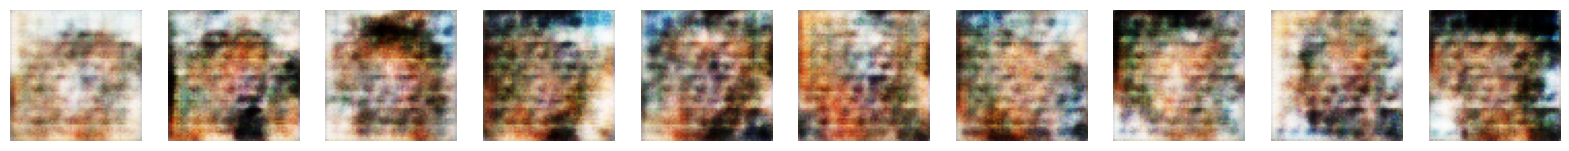

1/1 [==============================] - 4s 4s/step - c_loss: -2.5129 - c_wass_loss: -3.0201 - c_gp: 0.0507 - g_loss: -20.4694
Epoch 1401/2000
1/1 [==============================] - 4s 4s/step - c_loss: -7.1149 - c_wass_loss: -7.5568 - c_gp: 0.0442 - g_loss: -18.1993
Epoch 1402/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.9500 - c_wass_loss: -7.3202 - c_gp: 0.0370 - g_loss: -18.5412
Epoch 1403/2000
1/1 [==============================] - 3s 3s/step - c_loss: -3.9960 - c_wass_loss: -4.4325 - c_gp: 0.0437 - g_loss: -18.5207
Epoch 1404/2000
1/1 [==============================] - 3s 3s/step - c_loss: -2.5740 - c_wass_loss: -3.1048 - c_gp: 0.0531 - g_loss: -21.7223
Epoch 1405/2000
1/1 [==============================] - 3s 3s/step - c_loss: -6.4629 - c_wass_loss: -7.1138 - c_gp: 0.0651 - g_loss: -19.4447
Epoch 1406/2000
1/1 [==============================] - 3s 3s/step - c_loss: -9.4437 - c_wass_loss: -10.1593 - c_gp: 0.0716 - g_loss: -17.8729
Epoch 1407/2000
1/1 [=======

In [16]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [17]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


## Generate images

1/1 [==============================] - 0s 99ms/step


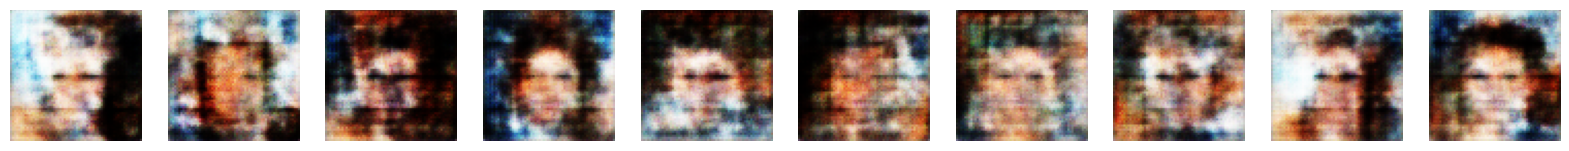

In [18]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

1/1 [==============================] - 0s 19ms/step


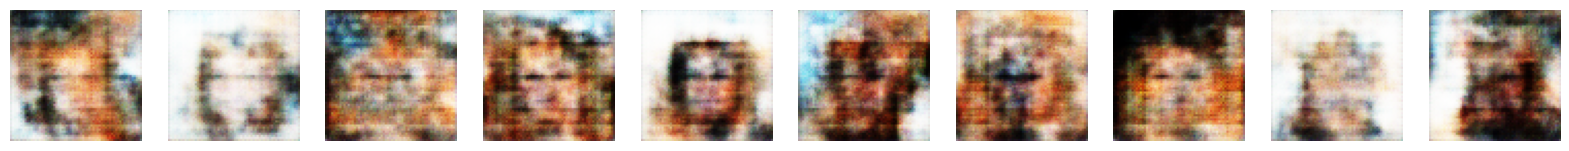

In [19]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)